## Discrete-time competitive Beverton-Holt model

\begin{align}
N_{1,t+1}=\dfrac{r_1N_{1,t}}{1+a_{11}N_{1,t}+a_{12}N_{2,t}} \\
N_{2,t+1}=\dfrac{r_2N_{2,t}}{1+a_{22}N_{2,t}+a_{21}N_{1,t}}
\tag{1}
\end{align}

## Packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

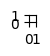

In [2]:
# Dummy plot
fig, ax = plt.subplots(figsize=(0.1, 0.1))
ax.axhline(y=1, color='grey', linestyle='--')
plt.rcParams.update({'font.size': 30})

## Parameters

In [3]:
#C12, C21 > 0: coexistence (always coexistence)
# converge -> coexist
r1=15
r2=11
a11=0.7
a12=0.2
a21=0.2
a22=0.2

SoS_1 = r2 / ( 1 + ( r2 - 1 ) * a12 / a22  )
SoS_2 = r1 / ( 1 + ( r1 - 1 ) * a21 / a11  )
print('SoS_1='+str(SoS_1)+',SoS_2='+str(SoS_2))

SoS_1=1.0,SoS_2=2.9999999999999996


In [4]:
# diverge -> extinction
r1=15
r2=11
a11=0.7
a12=0.4
a21=0.1
a22=0.2

SoS_1 = r1 / ( 1 + ( r2 - 1 ) * a12 / a22  )
SoS_2 = r2 / ( 1 + ( r1 - 1 ) * a21 / a11  )
print('SoS_1='+str(SoS_1)+',SoS_2='+str(SoS_2))

SoS_1=0.7142857142857143,SoS_2=3.666666666666666


In [5]:
# borderline (change initial conditions and the solution will change)
r1 = 15
r2 = 15
a11 = 0.3
a12 = 0.1
a21 = 0.3
a22 = 0.1

SoS_1 = r1 / ( 1 + ( r2 - 1 ) * a12 / a22  )
SoS_2 = r2 / ( 1 + ( r1 - 1 ) * a21 / a11  )
print('SoS_1='+str(SoS_1)+',SoS_2='+str(SoS_2))

SoS_1=1.0,SoS_2=0.9999999999999999


In [6]:
# N1 wins (according to annplant_2spp_det_rare.txt, N2 should win)
r1 = 16
r2 = 15
a11 = 0.1
a12 = 0.1
a21 = 0.1
a22 = 0.1

SoS_1 = r1 / ( 1 + ( r2 - 1 ) * a12 / a22  )
SoS_2 = r2 / ( 1 + ( r1 - 1 ) * a21 / a11  )
print('SoS_1='+str(SoS_1)+',SoS_2='+str(SoS_2))

SoS_1=1.0666666666666667,SoS_2=0.9375


In [7]:
cond1_left = a12
cond1_right = a22 * (r1 - 1) / (r2 - 1)
cond2_left = a21
cond2_right = a11 * (r2 - 1) / (r1 - 1)

cond2_right

0.09333333333333334

In [8]:
def getEqDensity(r1, r2, a11, a12, a21, a22): # Coexistence equilibrium populations
    denominator1 = a11 - (a21 * a12) / a22
    denominator2 = a22 - (a21 * a12) / a11
    N1 = (r1 - 1 - (a12 / a22) * (r2 - 1)) / denominator1 if denominator1 != 0 else np.nan
    N2 = (r2 - 1 - (a21 / a11) * (r1 - 1)) / denominator2 if denominator2 != 0 else np.nan
    if np.isinf(N1) or np.isinf(N2) or np.isnan(N1) or np.isnan(N2):
        initialNsp1 = 0
        initialNsp2 = 0
        N = np.zeros((100, 2))
        N[0, :] = [initialNsp1, initialNsp2]  
        for i in range(1, 100):
            N[i, 0] = max((r1 - 1 - a12 * N[i-1, 1]) / a11, 0)
            N[i, 1] = max((r2 - 1 - a21 * N[i-1, 0]) / a22, 0)
        N1 = np.mean(N[:, 0])
        N2 = np.mean(N[:, 1])
    if N1 < 0 and N2 >= 0:
        N1, N2 = 0.0, (r2 - 1) / a22 if a22 != 0 else 0.0
    elif N2 < 0 and N1 >= 0:
        N1, N2 = (r1 - 1) / a11 if a11 != 0 else 0.0, 0.0
    elif N1 < 0 and N2 < 0:
        N1, N2 = 0.0, 0.0
    return N1, N2

y1, y2 = getEqDensity(r1, r2, a11, a12, a21, a22)
print(y1, y2)

0.0 140.0


@jit(nopython=True)
def time_simul(y01, y02, r1, r2, a11, a22, a12, a21):
    y1 = np.array([5.0], dtype=np.float64)
    y2 = np.array([5.0], dtype=np.float64)
    stop_run = False
    i = 0
    while not stop_run and i < 10000:
        denom1 = 1 + a11 * y1[i] + a12 * y2[i]
        denom2 = 1 + a22 * y2[i] + a21 * y1[i]
        per_cap1 = r1 / denom1
        per_cap2 = r2 / denom2
        new_y1 = y1[i] * per_cap1
        new_y2 = y2[i] * per_cap2
        y1 = np.append(y1, new_y1)
        y2 = np.append(y2, new_y2)
        if i >= 1:
            if (abs(y1[-1] - y1[-2]) < 1e-6 and abs(y2[-1] - y2[-2]) < 1e-6):
                stop_run = True
        i += 1
    return y1, y2

In [9]:
@jit(nopython=True)
def time_simul(r1, r2, a11, a22, a12, a21, y01=5.0, y02=5.0, eps=1e-6):
    y1 = np.array([y01], dtype=np.float64)
    y2 = np.array([y02], dtype=np.float64)
    stop_run = False
    i = 0
    while not stop_run and i < 1000:
        denom1 = 1 + a11 * y1[i] + a12 * y2[i]
        denom2 = 1 + a22 * y2[i] + a21 * y1[i]
        per_cap1 = r1 / denom1
        per_cap2 = r2 / denom2
        new_y1 = y1[i] * per_cap1
        new_y2 = y2[i] * per_cap2
        y1 = np.append(y1, new_y1)
        y2 = np.append(y2, new_y2)
        if i >= 1:
            if (abs(y1[-1] - y1[-2]) < eps and abs(y2[-1] - y2[-2]) < eps):
                stop_run = True
        i += 1
    return y1, y2

In [10]:
def plot_dynamics(r1, r2, a11, a12, a21, a22, y01, y02, focal_species=None, fixed_species=None):
    y1, y2 = time_simul(r1, r2, a11, a22, a12, a21, y01, y02)
    print(y1[-1], y2[-1])
    tmax = len(y1)
    time = np.linspace(1, tmax, tmax)
    # Plotting N_t
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.plot(time, y1, alpha=0.5, marker="o", linewidth=10, markersize=12, color="blue", label='$N_{1}$')
    ax.plot(time, y2, alpha=0.5, marker="o", linewidth=10, markersize=12, color="orange", label='$N_{2}$')
    ax.set(xlabel='Time', ylabel='$N_{t}$')
    ax.axhline(y=0, color='grey', linestyle='--')
    ax.legend()
    plt.rcParams.update({'font.size': 30})
    plt.tight_layout()
    os.makedirs('img_time_series', exist_ok=True)
    plt.savefig('img_time_series/time_series_r1_'+str(r1)+'_r2_'+str(r2)+'_a11_'+str(a11)+'_a12_'+str(a12)+'_a21_'+str(a21)+'_a22_'+str(a22)+'_N01_'+str(y01)+'_N02_'+str(y02)+'.pdf', format='pdf', dpi=300)
    plt.show()

In [11]:
def check_analytical_scenarios_beverton_holt(r1, r2, a11, a12, a21, a22):
    # Avoid division by zero
    if r1 <= 1 or r2 <= 1:
        return 'invalid'
    # Calculate the analytical conditions
    cond1_left = a12
    cond1_right = a22 * (r1 - 1) / (r2 - 1)
    cond2_left = a21
    cond2_right = a11 * (r2 - 1) / (r1 - 1)
    # Check the four scenarios
    if cond1_left < cond1_right and cond2_left > cond2_right:
        return 'species1_wins'
    elif cond1_left > cond1_right and cond2_left < cond2_right:
        return 'species2_wins'
    elif cond1_left < cond1_right and cond2_left < cond2_right:
        return 'stable_coexistence'
    elif cond1_left > cond1_right and cond2_left > cond2_right:
        return 'saddle_point'
    else:
        return 'borderline'  # Edge cases where inequalities are equal

check_analytical_scenarios_beverton_holt(r1, r2, a11, a12, a21, a22)

'species1_wins'

149.9999851801156 1.383189210182923e-05


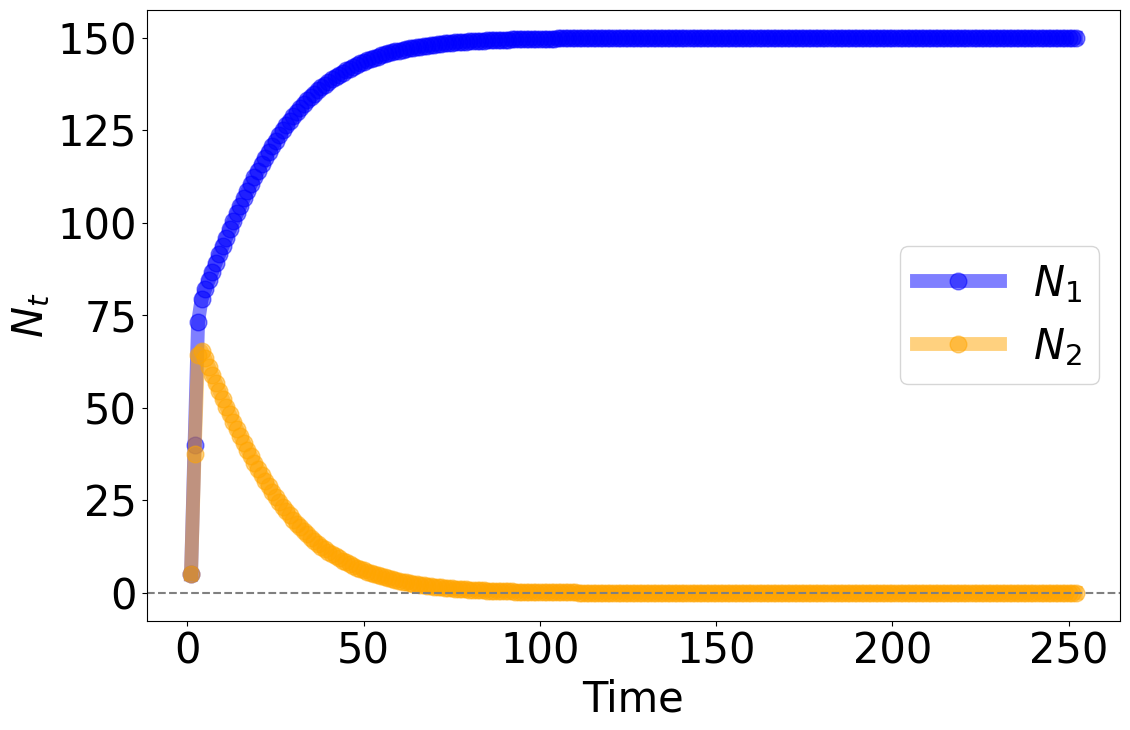

In [12]:
def main():
    # Initialize
    tmax = 200 # the code automatically adapts the tmax
    y1, y2 = np.zeros(tmax), np.zeros(tmax)
    y01, y02 = 5, 5 # initial conditions
    y1[0], y2[0] = y01, y02
    # Plot Two Species Dynamics
    plot_dynamics(r1, r2, a11, a12, a21, a22, y01, y02)

if __name__ == "__main__":
    main()